# Description

This notebook contains tools for debugging an individual `CcxtBroker` execution.

The notebook is responsible for aspects of the execution experiment run that are related to the correctness of the execution, as opposed to the analysis of the result:
- Consistency of logging
- Correctness in the submission of orders
- Consistency between trades and submitted orders
- Order time profiling

In [1]:
%load_ext autoreload
%autoreload 2

import logging

import pandas as pd

import core.config as cconfig
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hprint as hprint
import oms.broker.ccxt.ccxt_aggregation_functions as obccagfu
import oms.broker.ccxt.ccxt_logs_reader as obcclore

/app/amp/core/signal_processing/decorrelation.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-32e29661-09f2-4647-89e0-486d94416252.json'
-----------------------------------------------------------------------------
This code is not in sync with the container:
code_version='1.5.0' != container_version='1.4.0'
-----------------------------------------------------------------------------
You need to:
- merge origin/master into your branch with `invoke git_merge_master`
- pull the latest container with `invoke docker_pull`
INFO  # Git
  branch_name='CMTask4920_time_profiling_1'
  hash='db7899e01'
  # Last commits:
    * db7899e01 Paul     Cmamp task5027 add makertaker breakdown to transaction costpnl analysis in notebook (#5032) (   4 hours ago) Mon Aug 14 16:08:40 2023  (HEAD -> CMTask4920_time_profiling_1, origin/master, origin/HEAD, origin/CmampTask5033_Add_breakdown_according_to_whether_realized_pnl_is_positive_in_Master_execution_analysis.py, master)
    * b49de259

In [3]:
config = cconfig.get_config_from_env()
if config:
    # Get config from env when running the notebook via the `run_notebook.py` script, e.g.,
    # in the system reconciliation flow.
    _LOG.info("Using config from env vars")
else:
    system_log_dir = "/shared_data/ecs/test/twap_experiment/20230814_1"
    config_dict = {"system_log_dir": system_log_dir}
    config = cconfig.Config.from_dict(config_dict)
print(config)

system_log_dir: /shared_data/ecs/test/twap_experiment/20230814_1


In [4]:
log_dir = config["system_log_dir"]
ccxt_log_reader = obcclore.CcxtLogsReader(log_dir)
#
data = ccxt_log_reader.load_all_data()
ccxt_order_response_df = data["ccxt_order_responses"]
ccxt_trades_df = data["ccxt_trades"]
oms_child_order_df = data["oms_child_orders"]
oms_parent_order_df = data["oms_parent_orders"]

Loading files from '/shared_data/ecs/test/twap_experiment/20230814_1/ccxt_child_order_responses':   0%|       …

Loading files from '/shared_data/ecs/test/twap_experiment/20230814_1/oms_parent_orders':   0%|          | 0/5 …

Loading files from '/shared_data/ecs/test/twap_experiment/20230814_1/child_order_fills/ccxt_trades':   0%|    …

Loading files from '/shared_data/ecs/test/twap_experiment/20230814_1/oms_child_orders':   0%|          | 0/620…

Loading files from '/shared_data/ecs/test/twap_experiment/20230814_1/child_order_fills/oms_fills':   0%|      …

Loading `/shared_data/ecs/test/twap_experiment/20230814_1/child_order_fills/ccxt_fills` files...:   0%|       …

In [5]:
ccxt_order_response_df.head(3)

,info,order,client_order_id,timestamp,datetime,last_trade_timestamp,lastUpdateTimestamp,symbol,order_type,time_in_force,post_only,reduce_only,side,order_price,triggerPrice,order_amount,cost,average,filled,remaining,status,fee,trades,fees,stop_price,takeProfitPrice,stopLossPrice,order_update_timestamp,order_update_datetime
0,"{'orderId': '11978567410', 'symbol': 'GMTUSDT'...",11978567410,x-xcKtGhcua696504fa76a1e6db09a42,1692039902305,2023-08-14T19:05:02.305Z,NaN,1692039902305,GMT/USDT:USDT,limit,GTC,False,False,sell,0.2033,None,151.0,0.0,NaN,0.0,151.0,open,"{'currency': None, 'cost': None, 'rate': None}",[],"[{'currency': None, 'cost': None, 'rate': None}]",None,None,None,1692039902305,2023-08-14 19:05:02.305000+00:00
1,"{'orderId': '11978569826', 'symbol': 'GMTUSDT'...",11978569826,x-xcKtGhcuea05684007c4f773d23ab8,1692039962767,2023-08-14T19:06:02.767Z,NaN,1692039962767,GMT/USDT:USDT,limit,GTC,False,False,sell,0.2032,None,151.0,0.0,NaN,0.0,151.0,open,"{'currency': None, 'cost': None, 'rate': None}",[],"[{'currency': None, 'cost': None, 'rate': None}]",None,None,None,1692039962767,2023-08-14 19:06:02.767000+00:00
2,"{'orderId': '11978572688', 'symbol': 'GMTUSDT'...",11978572688,x-xcKtGhcu29ea7c262adda3cde2145d,1692040022449,2023-08-14T19:07:02.449Z,NaN,1692040022449,GMT/USDT:USDT,limit,GTC,False,False,sell,0.2031,None,151.0,0.0,NaN,0.0,151.0,open,"{'currency': None, 'cost': None, 'rate': None}",[],"[{'currency': None, 'cost': None, 'rate': None}]",None,None,None,1692040022449,2023-08-14 19:07:02.449000+00:00


In [6]:
oms_parent_order_df.iloc[0]["extra_params"]

{'stats': {'submit_twap_orders::start': Timestamp('2023-08-14 15:02:51.889764-0400', tz='America/New_York'),
  'submit_twap_orders::align_with_parent_order.start': Timestamp('2023-08-14 15:02:51.896424-0400', tz='America/New_York'),
  'submit_twap_orders::align_with_parent_order.end': Timestamp('2023-08-14 15:05:00.002929-0400', tz='America/New_York'),
  '_submit_twap_child_orders::bid_ask_market_data.start.0': Timestamp('2023-08-14 15:05:00.011385-0400', tz='America/New_York'),
  '_submit_twap_child_orders::bid_ask_market_data.done.0': Timestamp('2023-08-14 15:05:00.141460-0400', tz='America/New_York'),
  '_submit_twap_child_orders::get_open_positions.done.0': Timestamp('2023-08-14 15:05:01.180051-0400', tz='America/New_York'),
  '_submit_twap_child_orders::order_coroutines_created.0': Timestamp('2023-08-14 15:05:01.181357-0400', tz='America/New_York'),
  '_submit_twap_child_order::start.0': Timestamp('2023-08-14 15:05:01.211068-0400', tz='America/New_York'),
  '_submit_twap_child_ord

## Child order responses

In [7]:
ccxt_order_response_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   info                    600 non-null    object             
 1   order                   600 non-null    object             
 2   client_order_id         600 non-null    object             
 3   timestamp               600 non-null    int64              
 4   datetime                600 non-null    object             
 5   last_trade_timestamp    41 non-null     float64            
 6   lastUpdateTimestamp     600 non-null    int64              
 7   symbol                  600 non-null    object             
 8   order_type              600 non-null    object             
 9   time_in_force           600 non-null    object             
 10  post_only               600 non-null    bool               
 11  reduce_only             600 non-null    bool 

## Child orders

In [8]:
# If the value of total child orders is lower than expected,
oms_child_order_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 620 entries, 29 to 737
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   creation_timestamp      620 non-null    datetime64[ns, UTC]
 1   asset_id                620 non-null    int64              
 2   type_                   620 non-null    object             
 3   start_timestamp         620 non-null    datetime64[ns, UTC]
 4   end_timestamp           620 non-null    datetime64[ns, UTC]
 5   curr_num_shares         620 non-null    float64            
 6   diff_num_shares         620 non-null    float64            
 7   tz                      620 non-null    object             
 8   extra_params            620 non-null    object             
 9   passivity_factor        620 non-null    float64            
 10  latest_bid_price        620 non-null    float64            
 11  latest_ask_price        620 non-null    floa

In [9]:
oms_child_order_df.head(3)

,creation_timestamp,asset_id,type_,start_timestamp,end_timestamp,curr_num_shares,diff_num_shares,tz,extra_params,passivity_factor,latest_bid_price,latest_ask_price,bid_price_mean,ask_price_mean,used_bid_price,used_ask_price,exchange_timestamp,knowledge_timestamp,end_download_timestamp,limit_price,ccxt_id,name
order_id,,,,,,,,,,,,,,,,,,,,,,
29,2023-08-14 19:05:01.251615+00:00,1030828978,limit,2023-08-14 19:05:01.251615+00:00,2023-08-14 19:06:00+00:00,-72.0,-151.0,America/New_York,"{'oms_parent_order_id': 4, 'stats': {'_submit_...",0.55,0.2032,0.2033,0.2032,0.2033,latest_bid_price,latest_ask_price,2023-08-14 19:04:57.901000+00:00,2023-08-14 19:04:59.898352+00:00,2023-08-14 19:04:58.051702+00:00,0.203255,[11978567410],29
54,2023-08-14 19:06:02.428182+00:00,1030828978,limit,2023-08-14 19:06:02.428182+00:00,2023-08-14 19:07:00+00:00,-72.0,-151.0,America/New_York,"{'oms_parent_order_id': 4, 'stats': {'_submit_...",0.55,0.2031,0.2032,0.2031,0.2032,latest_bid_price,latest_ask_price,2023-08-14 19:05:57.931000+00:00,2023-08-14 19:05:58.501826+00:00,2023-08-14 19:05:58.206051+00:00,0.203155,[11978569826],54
79,2023-08-14 19:07:02.100258+00:00,1030828978,limit,2023-08-14 19:07:02.100258+00:00,2023-08-14 19:08:00+00:00,-72.0,-151.0,America/New_York,"{'oms_parent_order_id': 4, 'stats': {'_submit_...",0.55,0.2030,0.2031,0.2030,0.2031,latest_bid_price,latest_ask_price,2023-08-14 19:06:59.760000+00:00,2023-08-14 19:07:01.478308+00:00,2023-08-14 19:06:59.997394+00:00,0.203055,[11978572688],79


### Verify that OMS child orders have maximum of one CCXT order ID

Originally the CCXT IDs are loaded as `List[str]`. Each child order should correspond to 1 CCXT ID (`-1` in case the order was not submitted).

Exceptions to this rule indicate a serious error in accounting.

In [10]:
all(oms_child_order_df["ccxt_id"].apply(lambda x: len(x)) == 1)

True

In [11]:
# Unpack single CCXT IDs from lists.
oms_child_order_df["ccxt_id_as_single_str"] = oms_child_order_df["ccxt_id"].apply(
    lambda x: str(x[0])
)

### Extract the OMS parent order ID

In [12]:
oms_child_order_df["parent_order_id"] = oms_child_order_df["extra_params"].apply(
    lambda x: x["oms_parent_order_id"]
)
oms_child_order_df.head(3)

,creation_timestamp,asset_id,type_,start_timestamp,end_timestamp,curr_num_shares,diff_num_shares,tz,extra_params,passivity_factor,latest_bid_price,latest_ask_price,bid_price_mean,ask_price_mean,used_bid_price,used_ask_price,exchange_timestamp,knowledge_timestamp,end_download_timestamp,limit_price,ccxt_id,name,ccxt_id_as_single_str,parent_order_id
order_id,,,,,,,,,,,,,,,,,,,,,,,,
29,2023-08-14 19:05:01.251615+00:00,1030828978,limit,2023-08-14 19:05:01.251615+00:00,2023-08-14 19:06:00+00:00,-72.0,-151.0,America/New_York,"{'oms_parent_order_id': 4, 'stats': {'_submit_...",0.55,0.2032,0.2033,0.2032,0.2033,latest_bid_price,latest_ask_price,2023-08-14 19:04:57.901000+00:00,2023-08-14 19:04:59.898352+00:00,2023-08-14 19:04:58.051702+00:00,0.203255,[11978567410],29,11978567410,4
54,2023-08-14 19:06:02.428182+00:00,1030828978,limit,2023-08-14 19:06:02.428182+00:00,2023-08-14 19:07:00+00:00,-72.0,-151.0,America/New_York,"{'oms_parent_order_id': 4, 'stats': {'_submit_...",0.55,0.2031,0.2032,0.2031,0.2032,latest_bid_price,latest_ask_price,2023-08-14 19:05:57.931000+00:00,2023-08-14 19:05:58.501826+00:00,2023-08-14 19:05:58.206051+00:00,0.203155,[11978569826],54,11978569826,4
79,2023-08-14 19:07:02.100258+00:00,1030828978,limit,2023-08-14 19:07:02.100258+00:00,2023-08-14 19:08:00+00:00,-72.0,-151.0,America/New_York,"{'oms_parent_order_id': 4, 'stats': {'_submit_...",0.55,0.2030,0.2031,0.2030,0.2031,latest_bid_price,latest_ask_price,2023-08-14 19:06:59.760000+00:00,2023-08-14 19:07:01.478308+00:00,2023-08-14 19:06:59.997394+00:00,0.203055,[11978572688],79,11978572688,4


In [13]:
# Check how many child orders are generated per parent_order_id.
oms_child_order_df["parent_order_id"].value_counts().value_counts()

5    124
Name: parent_order_id, dtype: int64

### Check the error messages in non-submitted orders.

In [14]:
# Select the OMS child orders with no CCXT ID and check their error messages.
not_submitted_oms_child_order_df = oms_child_order_df.loc[
    oms_child_order_df["ccxt_id_as_single_str"] == "-1"
]
print(
    "Number of not submitted OMS child orders=%s out of total orders=%s"
    % (not_submitted_oms_child_order_df.shape[0], oms_child_order_df.shape[0])
)

Number of not submitted OMS child orders=20 out of total orders=620


In [15]:
# Extract all error messages from unsubmitted orders.
not_submitted_oms_child_order_df["error_msg"] = not_submitted_oms_child_order_df[
    "extra_params"
].apply(lambda x: x["error_msg"])
not_submitted_oms_child_order_df["error_msg"].value_counts()

binance {"code":-4164,"msg":"Order's notional must be no smaller than 5 (unless you choose reduce only)."}    20
Name: error_msg, dtype: int64

## Parent orders

In [16]:
oms_parent_order_df.head(3)

,creation_timestamp,asset_id,type_,start_timestamp,end_timestamp,curr_num_shares,diff_num_shares,tz,extra_params
order_id,,,,,,,,,
0,2023-08-14 19:05:00+00:00,1464553467,price@twap,2023-08-14 19:05:00+00:00,2023-08-14 19:10:00+00:00,0.0,-0.038426,UTC,{'stats': {'submit_twap_orders::start': 2023-0...
1,2023-08-14 19:05:00+00:00,1467591036,price@twap,2023-08-14 19:05:00+00:00,2023-08-14 19:10:00+00:00,0.0,0.003548,UTC,{'stats': {'submit_twap_orders::start': 2023-0...
2,2023-08-14 19:05:00+00:00,4516629366,price@twap,2023-08-14 19:05:00+00:00,2023-08-14 19:10:00+00:00,0.0,514.757392,UTC,{'stats': {'submit_twap_orders::start': 2023-0...


In [17]:
oms_parent_order_df["child_order_ccxt_ids"] = oms_parent_order_df[
    "extra_params"
].apply(lambda x: x["ccxt_id"])
oms_parent_order_df.head(3)

,creation_timestamp,asset_id,type_,start_timestamp,end_timestamp,curr_num_shares,diff_num_shares,tz,extra_params,child_order_ccxt_ids
order_id,,,,,,,,,,
0,2023-08-14 19:05:00+00:00,1464553467,price@twap,2023-08-14 19:05:00+00:00,2023-08-14 19:10:00+00:00,0.0,-0.038426,UTC,{'stats': {'submit_twap_orders::start': 2023-0...,"[8389765612517381956, 8389765612517484486, 838..."
1,2023-08-14 19:05:00+00:00,1467591036,price@twap,2023-08-14 19:05:00+00:00,2023-08-14 19:10:00+00:00,0.0,0.003548,UTC,{'stats': {'submit_twap_orders::start': 2023-0...,"[180292745435, 180292933153, 180293063420, 180..."
2,2023-08-14 19:05:00+00:00,4516629366,price@twap,2023-08-14 19:05:00+00:00,2023-08-14 19:10:00+00:00,0.0,514.757392,UTC,{'stats': {'submit_twap_orders::start': 2023-0...,"[13935179300, 13935187440, 13935197474, 139352..."


In [18]:
# Check how many child orders per parent order were successfully submitted.
# A value between maximum expected and 0 can mean that some child orders
# could not get through, while otherwise being well-formed.
# A value of 0 means that the parent order had an issue, e.g.
# having a notional that made all child orders below a minimum.
oms_parent_order_df["submitted_child_order_num"] = oms_parent_order_df[
    "child_order_ccxt_ids"
].str.len()
oms_parent_order_df["submitted_child_order_num"].value_counts()

5    120
0      5
Name: submitted_child_order_num, dtype: int64

## Trades

In [19]:
ccxt_trades_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 375 entries, 2023-08-14 19:05:04.294000+00:00 to 2023-08-14 19:29:04.490000+00:00
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   timestamp         375 non-null    datetime64[ns, UTC]
 1   datetime          375 non-null    datetime64[ns, UTC]
 2   symbol            375 non-null    object             
 3   asset_id          375 non-null    int64              
 4   id                375 non-null    object             
 5   order             375 non-null    object             
 6   side              375 non-null    object             
 7   takerOrMaker      375 non-null    object             
 8   price             375 non-null    float64            
 9   amount            375 non-null    float64            
 10  cost              375 non-null    float64            
 11  transaction_cost  375 non-null    float64            
 12  f

### Verify that all trades correspond to logged child orders

In [20]:
# Verify that all trades have an associated order response.
# If the trade does not have an associated order, it means
# that a trade was executed that was not accounted for during the experiment.
all(ccxt_trades_df["order"].isin(ccxt_order_response_df["order"]))

True

In [21]:
# Verify that all trades have an associated 'ccxt_id' in OMS child orders.
# This verifies that there is a consistency between a CCXT order, OMS order and
# a CCXT trade. If a trade has no associated OMS child order `ccxt_id`, it means
# that an unexpected trade was executed, for example, by a different actor on the same account.
all(ccxt_trades_df["order"].isin(oms_child_order_df["ccxt_id_as_single_str"]))

True

### Check orders that do not correspond to any trades

In [22]:
# Existence of such orders is not necessarily a bug.
# It means that a given OMS child order was not filled.
child_orders_with_no_trades = ~oms_child_order_df["ccxt_id_as_single_str"].isin(
    ccxt_trades_df["order"]
)
child_orders_with_no_trades.sum()

266

In [23]:
oms_child_order_df.loc[child_orders_with_no_trades]

,creation_timestamp,asset_id,type_,start_timestamp,end_timestamp,curr_num_shares,diff_num_shares,tz,extra_params,passivity_factor,latest_bid_price,latest_ask_price,bid_price_mean,ask_price_mean,used_bid_price,used_ask_price,exchange_timestamp,knowledge_timestamp,end_download_timestamp,limit_price,ccxt_id,name,ccxt_id_as_single_str,parent_order_id
order_id,,,,,,,,,,,,,,,,,,,,,,,,
29,2023-08-14 19:05:01.251615+00:00,1030828978,limit,2023-08-14 19:05:01.251615+00:00,2023-08-14 19:06:00+00:00,-72.000,-151.000,America/New_York,"{'oms_parent_order_id': 4, 'stats': {'_submit_...",0.55,0.20320,0.20330,0.203200,0.203300,latest_bid_price,latest_ask_price,2023-08-14 19:04:57.901000+00:00,2023-08-14 19:04:59.898352+00:00,2023-08-14 19:04:58.051702+00:00,0.203255,[11978567410],29,11978567410,4
54,2023-08-14 19:06:02.428182+00:00,1030828978,limit,2023-08-14 19:06:02.428182+00:00,2023-08-14 19:07:00+00:00,-72.000,-151.000,America/New_York,"{'oms_parent_order_id': 4, 'stats': {'_submit_...",0.55,0.20310,0.20320,0.203100,0.203200,latest_bid_price,latest_ask_price,2023-08-14 19:05:57.931000+00:00,2023-08-14 19:05:58.501826+00:00,2023-08-14 19:05:58.206051+00:00,0.203155,[11978569826],54,11978569826,4
79,2023-08-14 19:07:02.100258+00:00,1030828978,limit,2023-08-14 19:07:02.100258+00:00,2023-08-14 19:08:00+00:00,-72.000,-151.000,America/New_York,"{'oms_parent_order_id': 4, 'stats': {'_submit_...",0.55,0.20300,0.20310,0.203000,0.203100,latest_bid_price,latest_ask_price,2023-08-14 19:06:59.760000+00:00,2023-08-14 19:07:01.478308+00:00,2023-08-14 19:06:59.997394+00:00,0.203055,[11978572688],79,11978572688,4
104,2023-08-14 19:08:02.024886+00:00,1030828978,limit,2023-08-14 19:08:02.024886+00:00,2023-08-14 19:09:00+00:00,-72.000,-151.000,America/New_York,"{'oms_parent_order_id': 4, 'stats': {'_submit_...",0.55,0.20300,0.20310,0.203000,0.203100,latest_bid_price,latest_ask_price,2023-08-14 19:08:00.117000+00:00,2023-08-14 19:08:01.170779+00:00,2023-08-14 19:08:00.320091+00:00,0.203055,[11978574549],104,11978574549,4
129,2023-08-14 19:09:01.758582+00:00,1030828978,limit,2023-08-14 19:09:01.758582+00:00,2023-08-14 19:10:00+00:00,-72.000,-151.000,America/New_York,"{'oms_parent_order_id': 4, 'stats': {'_submit_...",0.55,0.20290,0.20300,0.202900,0.203000,latest_bid_price,latest_ask_price,2023-08-14 19:08:58.175000+00:00,2023-08-14 19:08:58.663019+00:00,2023-08-14 19:08:58.406575+00:00,0.202955,[11978577316],129,11978577316,4
179,2023-08-14 19:10:01.936309+00:00,1030828978,limit,2023-08-14 19:10:01.936309+00:00,2023-08-14 19:11:00+00:00,-72.000,53.000,America/New_York,"{'oms_parent_order_id': 154, 'stats': {'_submi...",0.55,0.20290,0.20300,0.202900,0.203000,latest_bid_price,latest_ask_price,2023-08-14 19:10:00.631000+00:00,2023-08-14 19:10:00.993592+00:00,2023-08-14 19:10:00.770855+00:00,0.202945,[11978581342],179,11978581342,154
204,2023-08-14 19:11:01.650526+00:00,1030828978,limit,2023-08-14 19:11:01.650526+00:00,2023-08-14 19:12:00+00:00,-72.000,53.000,America/New_York,"{'oms_parent_order_id': 154, 'stats': {'_submi...",0.55,0.20290,0.20300,0.202900,0.203000,latest_bid_price,latest_ask_price,2023-08-14 19:10:59.349000+00:00,2023-08-14 19:10:59.561610+00:00,2023-08-14 19:10:59.523613+00:00,0.202945,[11978583533],204,11978583533,154
229,2023-08-14 19:12:03.088758+00:00,1030828978,limit,2023-08-14 19:12:03.088758+00:00,2023-08-14 19:13:00+00:00,-72.000,53.000,America/New_York,"{'oms_parent_order_id': 154, 'stats': {'_submi...",0.55,0.20300,0.20310,0.203000,0.203100,latest_bid_price,latest_ask_price,2023-08-14 19:11:59.748000+00:00,2023-08-14 19:12:01.709500+00:00,2023-08-14 19:12:00.015380+00:00,0.203045,[11978586467],229,11978586467,154
254,2023-08-14 19:13:01.850483+00:00,1030828978,limit,2023-08-14 19:13:01.850483+00:00,2023-08-14 19:14:00+00:00,-72.000,53.000,America/New_York,"{'oms_parent_order_id': 154, 'stats': {'_submi...",0.55,0.20300,0.20310,0.203000,0.203100,latest_bid_price,latest_ask_price,2023-08-14 19:12:59.759000+00:00,2023-08-14 19:12:59.96421

### Check the correctness of trade amount
- Sum of `amount` of all trades related to a single child order should not exceed the total amount for that order.


In [24]:
# If the traded amount is larger than the order, it means that an extra trade
# is executed and the order is filled for a larger amount.
# This can mean an accounting error on the exchange side.
trade_amount_by_order = ccxt_trades_df.groupby("order").agg({"amount": sum})
accepted_child_order_df = oms_child_order_df.loc[
    oms_child_order_df["ccxt_id_as_single_str"] != "-1"
]
trade_amount_by_order["child_order_amount"] = accepted_child_order_df.set_index(
    "ccxt_id_as_single_str"
)["diff_num_shares"].abs()

In [25]:
mask = (
    trade_amount_by_order["amount"] > trade_amount_by_order["child_order_amount"]
)
trade_amount_by_order.loc[mask]

,amount,child_order_amount
order,,


### Verify that CCXT IDs are equal in both child orders and responses

In [26]:
# Verify that we are not logging any CCXT orders that are not a part
# of the experiment, i.e. have no OMS order associated with it.
# We expect all retrieved responses to be a subset of CCXT IDs
# connected to the OMS child orders.
submitted_oms_orders_ccxt_ids = set(
    oms_child_order_df.loc[oms_child_order_df["ccxt_id_as_single_str"] != "-1"][
        "ccxt_id_as_single_str"
    ].unique()
)
ccxt_response_ids = set(ccxt_order_response_df["order"].unique())
ccxt_response_ids.issubset(submitted_oms_orders_ccxt_ids)

True

# Group trades by order

In [27]:
# Aggregate fills by order.
# TODO(Danya): Rename to `aggregate_trades_by_order`
ccxt_trades_by_order = obccagfu.aggregate_fills_by_order(ccxt_trades_df)
ccxt_trades_by_order.head(3)

,first_timestamp,last_timestamp,first_datetime,last_datetime,symbol,asset_id,buy_count,sell_count,taker_count,maker_count,price,amount,cost,transaction_cost,realized_pnl
order,,,,,,,,,,,,,,,
10155119336,2023-08-14 19:05:28.238000+00:00,2023-08-14 19:05:28.238000+00:00,2023-08-14 19:05:28.238000+00:00,2023-08-14 19:05:28.238000+00:00,APE/USDT:USDT,6051632686,0,1,0,1,2.058,15.0,30.870,0.006174,0.000
10155259224,2023-08-14 19:12:21.914000+00:00,2023-08-14 19:12:21.914000+00:00,2023-08-14 19:12:21.914000+00:00,2023-08-14 19:12:21.914000+00:00,APE/USDT:USDT,6051632686,1,0,0,1,2.061,8.0,16.488,0.003298,-0.024
10155407831,2023-08-14 19:19:28.894000+00:00,2023-08-14 19:19:28.894000+00:00,2023-08-14 19:19:28.894000+00:00,2023-08-14 19:19:28.894000+00:00,APE/USDT:USDT,6051632686,0,1,0,1,2.062,10.0,20.620,0.004124,0.000


# Time profiling for child orders

In [28]:
oms_child_order_df = ccxt_log_reader.load_oms_child_order_df(
    unpack_extra_params=True
)

Loading files from '/shared_data/ecs/test/twap_experiment/20230814_1/oms_child_orders':   0%|          | 0/620…

In [29]:

def get_oms_child_order_timestamps(df, order_wave: int):
    stats = df["stats"].apply(
        pd.Series
    )
    # Select bid/ask timestamp columns from the DB.
    bid_ask_timestamp_cols = [
        "exchange_timestamp",
        "end_download_timestamp",
        "knowledge_timestamp",
    ]
    bid_ask_timestamps_df = df[bid_ask_timestamp_cols]
    # Combine all timestamp info into single dataframe.
    out_df = pd.concat([bid_ask_timestamps_df, stats], axis=1)
    timing_cols = submission_timestamp_cols = [
        f"_submit_twap_child_order::bid_ask_market_data.start.{order_wave}",
        f"_submit_twap_child_order::bid_ask_market_data.done.{order_wave}",
        f"_submit_twap_child_order::get_open_positions.done.{order_wave}",
        f"_submit_twap_child_order::child_order.created.{order_wave}",
        f"_submit_twap_child_order::child_order.limit_price_calculated.{order_wave}",
        "_submit_single_order_to_ccxt_with_retry::start.timestamp",
        "_submit_single_order_to_ccxt_with_retry::end.timestamp",
        f"_submit_twap_child_order::child_order.submitted.{order_wave}", 
    ]
    timing_cols = bid_ask_timestamp_cols + submission_timestamp_cols
    out_df = out_df[timing_cols].dropna(subset=submission_timestamp_cols)
    return out_df

def get_time_delay_between_events(df):
    """
    For each timestamp, get delay in seconds before the previous timestammp.
    """
    delays = df.subtract(df["exchange_timestamp"], axis=0)
    delays = delays.apply(lambda x: x.dt.total_seconds())
    # Verify that the timestamps increase left to right.
    hdbg.dassert_eq((delays.diff(axis=1) < 0).sum().sum(), 0)
    return delays

In [30]:
wave = get_oms_child_order_timestamps(oms_child_order_df, 0)

In [31]:
wave.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124 entries, 29 to 641
Data columns (total 11 columns):
 #   Column                                                          Non-Null Count  Dtype                           
---  ------                                                          --------------  -----                           
 0   exchange_timestamp                                              124 non-null    datetime64[ns, UTC]             
 1   end_download_timestamp                                          124 non-null    datetime64[ns, UTC]             
 2   knowledge_timestamp                                             124 non-null    datetime64[ns, UTC]             
 3   _submit_twap_child_order::bid_ask_market_data.start.0           124 non-null    datetime64[ns, America/New_York]
 4   _submit_twap_child_order::bid_ask_market_data.done.0            124 non-null    datetime64[ns, America/New_York]
 5   _submit_twap_child_order::get_open_positions.done.0            

In [32]:
time_delays = get_time_delay_between_events(wave)

<AxesSubplot: ylabel='Time delay'>

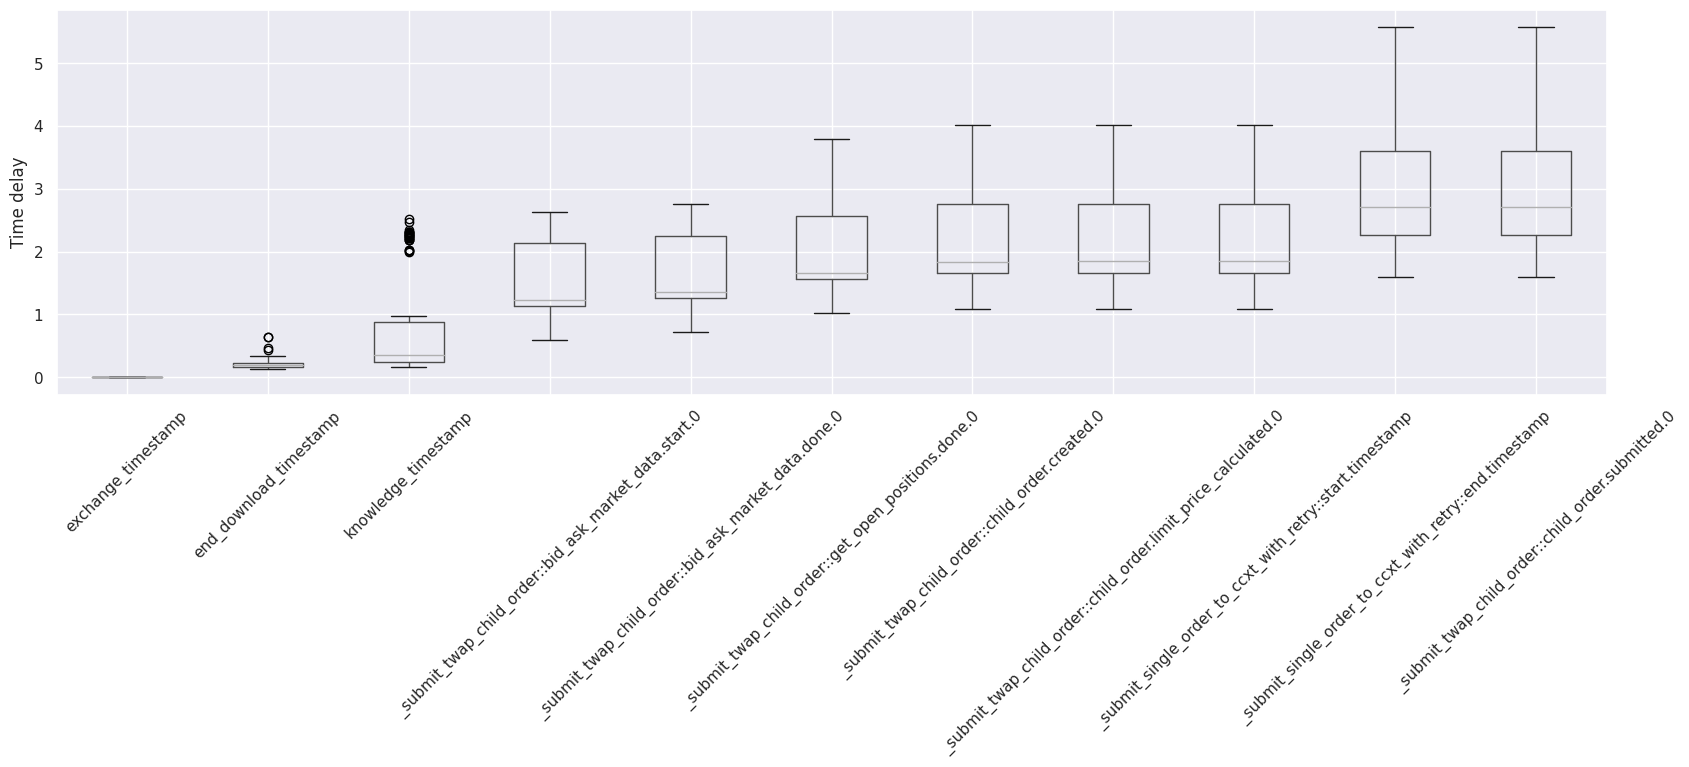

In [33]:
time_delays.boxplot(rot=45, ylabel="Time delay")